In [2]:
from model import STA_CNN_LSTM

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['simHei']
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.sans-serif'] = ['Kaiti']
from sklearn.metrics import r2_score

import data_fun as df

In [4]:
def load_data(sheet_name):
    print("Loading data...")
    
    #读取样本数据
    dataset = pd.read_excel(r'./data.xlsx',sheet_name=sheet_name)
    #print(type(dataset))
    dataset=np.array(dataset)[:,:]
    features = dataset[:, :]
    labels = dataset[:, :]
    
    return dataset,features,labels

from sklearn.preprocessing import StandardScaler
ss_x=StandardScaler()
ss_y=StandardScaler()
def normalize(mx,ss_x):  #可以用ss_x反归一化
    mx=ss_x.fit_transform(mx)
    return mx,ss_x

def rnn_data(data):
    n_feat=data.shape[1]
    n_num=data.shape[0]
    step=12
    data1=np.zeros((n_num-step,step,n_feat))
    labels=np.zeros((n_num-step,n_feat-1))
    #for i in range(n_feat):
    for j in range(0,n_num-step):
        data1[j,:,:]=data[j:j+step,:]
        labels[j,:]=data[j+step,:-1]
        
    return data1,labels

In [5]:
#加载数据
data,feat,lab=load_data('dis')  #excel的格式
datav,feat,lab=load_data('vel')
dataa,feat,lab=load_data('acc')
ldata,feat,lab=load_data('rain-water')


print(ldata.shape)
x_data = np.concatenate((data,datav,dataa),1)
y_data = data[:,:]
print(x_data.shape)

#归一化，c——data[108,46],ldata[116,4]
#划分数据集
xtr = x_data[:-5,:]
ytr = x_data[1:-6,:4]
xts = x_data[-6:,:]
yts = x_data[-6:,:4]
print(xts.shape)

Loading data...
Loading data...
Loading data...
Loading data...
(29, 3)
(18, 12)
(6, 12)


In [6]:
def crnn_data(data):
    n_feat=data.shape[1]
    n_num=data.shape[0]
    step=1
    data1=np.zeros((n_num-step,3,2,2))
    labels=np.zeros((n_num-step,4))
    for i in range(n_num-step):
        data1[i,:]=np.reshape(data[i:i+step,:],(3,2,2))
        labels[i]=data[i+step,:4]
    return data1,labels
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
ss_x=StandardScaler()
ss_x1=StandardScaler()
ss_y=StandardScaler()
ss_y0=StandardScaler()
ss_xl=StandardScaler()
#print(yts.shape)
cdata3,ss_x=normalize(xtr,ss_x)
ts_data3,ss_x1=normalize(xts,ss_x1)
ldata3,ss_xl = normalize(ldata,ss_xl)
tr_label,ss_y = normalize(ytr,ss_y)

ts_label,ss_y0 = normalize(yts,ss_y0)

data2,label2=rnn_data(ldata3)  #data所有列，label最后一列
tr_data,label3=crnn_data(cdata3)
ts_data,ts_label3=crnn_data(ts_data3)
print(ts_label3.shape)
print(data2.shape)
print(tr_data.shape,label3.shape)
print(ts_data.shape,ts_label3.shape)

print(cdata3.shape,ts_data3.shape,ldata3.shape,tr_label.shape,ts_label.shape)

(5, 4)
(17, 12, 3)
(12, 3, 2, 2) (12, 4)
(5, 3, 2, 2) (5, 4)
(13, 12) (6, 12) (29, 3) (11, 4) (6, 4)


In [7]:
cdata0=Variable(torch.Tensor(tr_data[1:,:,:]))
label0=Variable(torch.Tensor(label3[1:,:]))

x_test=Variable(torch.Tensor(ts_data))
y_test=Variable(torch.Tensor(ts_label3))  ################
#torch_dataset = Data.TensorDataset(data0,label0)

ldata0=Variable(torch.Tensor(data2[0:-6,:]))
lx_test=Variable(torch.Tensor(data2[-6:-1,:]))

#lx_test = Variable(torch.Tensor(data2[-12:,:]))
#label0=Variable(torch.Tensor(nor_data[0:-20,:]))

print(cdata0.shape,label0.shape)
print(x_test.shape,y_test.shape)
print(ldata0.shape,lx_test.shape)

torch.Size([11, 3, 2, 2]) torch.Size([11, 4])
torch.Size([5, 3, 2, 2]) torch.Size([5, 4])
torch.Size([11, 12, 3]) torch.Size([5, 12, 3])


In [8]:
def rmse(x,x2,y,model,ss_y,num):
    
    x1=x.clone()
    y_per=model(x1,x2)
    
    y_pre=y_per.data.numpy()
    y1=y.clone()
    y_train2=y1.data.numpy()
    
    y_pre1=ss_y.inverse_transform(y_pre)               #ss_x 三列  ss_X对x的两列  ss_y对y的一列
    y_tra=ss_y.inverse_transform(y_train2)

    y_pre2=np.reshape(y_pre1,num)
    y_tra1=np.reshape(y_tra,num)
    
    rmse01=((np.sum((y_pre2-y_tra1)**2))/num)**0.5
    #rmse01 = r2_score(y_pre2,y_tra1)
    return y_pre2,rmse01

def mape(x,x2,y,model,ss_y,num):
    x1=x.clone()
    y_per=model(x1,x2)
    y_pre=y_per.data.numpy()
    y1=y.clone()
    y_train2=y1.data.numpy()
    
    y_pre1=ss_y.inverse_transform(y_pre)               #ss_x 三列  ss_X对x的两列  ss_y对y的一列
    y_tra=ss_y.inverse_transform(y_train2)

    y_pre2=np.reshape(y_pre1,num)
    y_tra1=np.reshape(y_tra,num)
    
    mape01 = np.sum((((y_pre2-y_tra1))**2)**0.5)/num
    
    return y_pre2,mape01


def weight_init(m):
# 使用isinstance来判断m属于什么类型
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
# m中的weight，bias其实都是Variable，为了能学习参数以及后向传播
        m.weight.data.fill_(0.4)
        m.bias.data.zero_()

In [9]:
def fast_train(model):
    Epoch=100
    tra_loss,tes_loss = [],[]
    ls = []
    tra_a,tes_b = 12,20
    model_num = 0
    model1=model.train()
    model2=model.eval()
    for epoch in range(Epoch):
        del_data =np.random.randint(0,10,6)
        bx1 = np.delete(cdata0[1:], del_data, axis=0)
        bx2 = np.delete(ldata0[1:], del_data, axis=0)
        by = np.delete(label0[1:], del_data, axis=0)
        prediction = model(bx1,bx2)
        loss = loss_func(prediction, by)
        optimizer.zero_grad()
        loss.backward(loss.clone().detach())
        optimizer.step()
        
        y_pre,e_test=rmse(x_test,lx_test,y_test,model2,ss_y0,20)
        y_re2,e_train=rmse(cdata0[1:],ldata0[1:],
                               label0[1:],model2,ss_y0,40)

        if epoch % 5 == 4:  # 每2000个batch打印一次训练状态
            print('[%d] loss: %.4f, %.2f' \
                    % (epoch + 1, e_train, e_test))
            tra_loss.append(e_train)
            tes_loss.append(e_test)
        #v_loss = loss_func(model(x_test,lx_test), y_test)
        #early_stopping(v_loss, model)
        #if early_stopping.early_stop:
            #print("Early stopping")
            #break
    

    if model_num !=0:
        #torch.save(temp_model ,str(e_test)+'cnn-lstm16.plk')
        model_num = 1
        #return temp_model,e_train,e_test,tra_loss,tes_loss,ls
    else:
        temp_model = model
    # 
    #model.load_state_dict(torch.load('checkpoint.pt'))
    return temp_model,e_train,e_test,tra_loss,tes_loss,ls

class My_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        a=len(x)
        s=0
        x=x.view((-1,1))
        y = y.view((-1,1))
        #print(y)
        for i in range(a*4):
            if x[i]<y[i]:
                s+=torch.pow((x[i]-y[i]),2)
            else:
                s+=torch.pow((x[i]-y[i]),2)
        rm=((s/(a*4))**0.5)
        return rm

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


[5] loss: 3.5095, 4.98
[10] loss: 3.3814, 4.62
[15] loss: 3.2838, 4.61
[20] loss: 3.2057, 4.54
[25] loss: 3.1095, 4.48
[30] loss: 2.9722, 4.44
[35] loss: 2.8765, 4.46
[40] loss: 2.6136, 4.17
[45] loss: 2.3330, 3.82
[50] loss: 1.9545, 3.45
[55] loss: 1.6393, 3.10
[60] loss: 1.5493, 3.04
[65] loss: 1.3132, 2.88
[70] loss: 1.1354, 2.61
[75] loss: 1.0763, 2.52
[80] loss: 1.1341, 2.30
[85] loss: 1.1112, 2.46
[90] loss: 0.9711, 2.31
[95] loss: 0.9519, 2.20
[100] loss: 0.9130, 2.22
2.2166332194546405 1.3045062824418194
[]
[]
0.983746649449246


D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


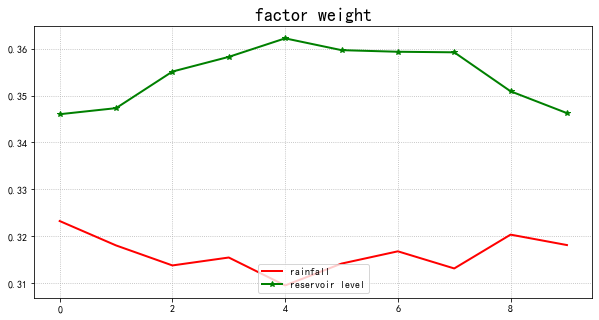

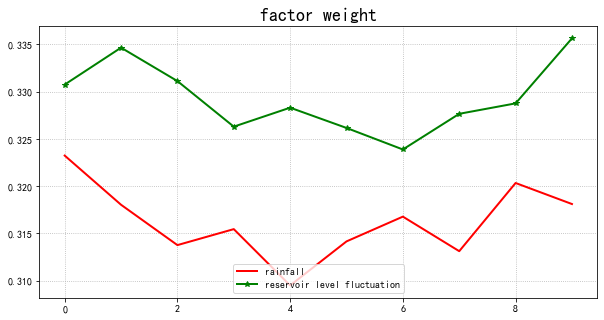

-8.399970200000098


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [24]:
import time
LR=0.0015
#loss_func = nn.MSELoss()
loss_func = My_loss()
star = time.clock()
for i in range(1):
    for j in range(1):
        model = STA_CNN_LSTM()
        weight_init(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=0.001)
        torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma=0.6, last_epoch=-1)
        tem_model,e_train,e_test,tra_loss,tes_loss,ls=fast_train(model)

        net1 = tem_model.eval()
        #net1 = CNN_LSTM()
        #checkpoint = torch.load('21.51cnn-lstm.pth')
        #net1.load_state_dict(checkpoint)

        y_pre,e_test=rmse(x_test,lx_test,y_test,net1,ss_y0,20)
        y_real=np.reshape(df.re_trafor(y_test,ss_y0),(-1,1))
        y_pre1,e_train=rmse(cdata0[0:10],ldata0[0:10],label0[0:10],net1,ss_y0,40)

        y_train=np.reshape(df.re_trafor(label0,ss_y0),(-1,1))
        print(e_test,e_train)
        print(y_pre[90:100].T)
        print(y_real[90:100].T)

        test_score = r2_score(y_pre,y_real)
        print(test_score)

    y_pre1,e_train=rmse(cdata0[1:],ldata0[1:],label0[1:],net1,ss_y0,40)

    #y_pre,e_test=rmse(x_test,lx_test,y_test,net1,ss_y0,180)
    factor_w = np.zeros((10,3))
    for i in range(10):
        cam = (net1.we3[0,i].data.numpy()).reshape((3))
        factor_w[i] = cam
        #print(cam)
    yreal = pd.DataFrame(factor_w)


    df.fig(factor_w[:,0],factor_w[:,1],10,'rainfall','reservoir level','factor weight')
    df.fig(factor_w[:,0],factor_w[:,2],10,'rainfall','reservoir level fluctuation','factor weight')
    end = time.clock()
    print(star-end)

D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


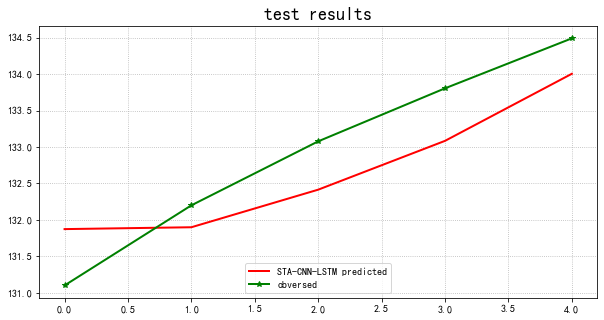

[0.6143477]


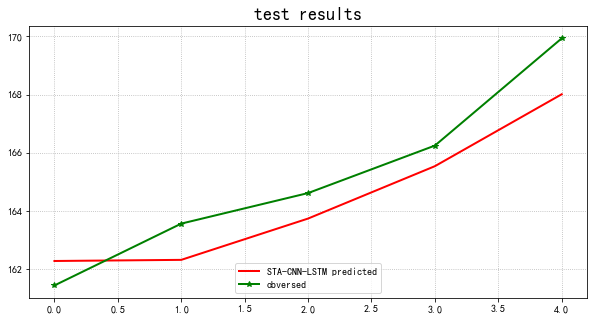

[1.2017589]


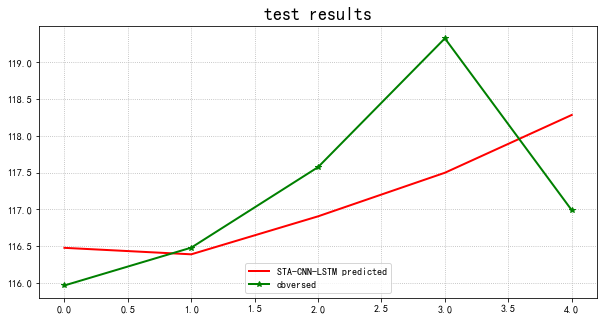

[1.072023]


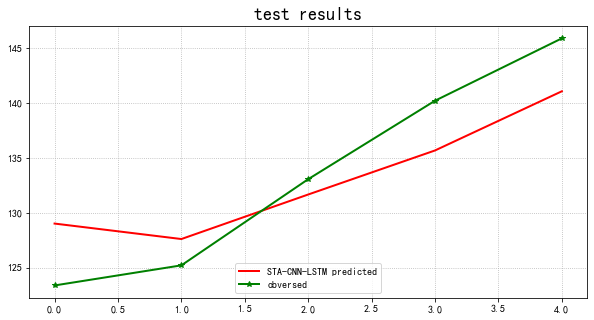

[4.0844793]
1.7431523


In [25]:
y_pre,e_test=rmse(x_test,lx_test,y_test,net1,ss_y0,20)
y_real=np.reshape(df.re_trafor(y_test,ss_y0),(-1,1))
def RMSE(pre,y_test):
    pre=np.array(pre)
    sum=0
    for i in range(len(pre)):
        sum+=(pre[i]-y_test[i])**2
    rmse=(sum/len(pre))**0.5
    return rmse
ave = []
for j in range(4):
    a= []
    b=[]
    for i in range(5):
        a.append(y_pre[4*i+j])
        b.append(y_real[4*i+j])
    df.fig(a,b,5,'STA-CNN-LSTM predicted','obversed','test results')  #测试集    
#print(a,b)
    print(RMSE(a,b))
    ave.append(RMSE(a,b))
print(np.mean(ave))

In [22]:
#temporal weights on a time step
print(net1.we4[4].T)

tensor([[0.0693, 0.0762, 0.0804, 0.0831, 0.0847, 0.0857, 0.0862, 0.0866, 0.0868,
         0.0869, 0.0870, 0.0871]], grad_fn=<PermuteBackward>)


In [23]:
#spatial attention weights
print(net1.we2[4][0].T)

tensor([[0.1785, 0.0548, 0.0483],
        [0.2612, 0.0802, 0.0817],
        [0.1386, 0.0712, 0.0854]], grad_fn=<PermuteBackward>)
